tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.183800,0.163052,0.938190



Classification Report:

              precision    recall  f1-score   support

    negative       0.85      0.91      0.88        56
     neutral       0.97      0.96      0.97       276
    positive       0.90      0.89      0.90       121

    accuracy                           0.94       453
   macro avg       0.91      0.92      0.91       453
weighted avg       0.94      0.94      0.94       453



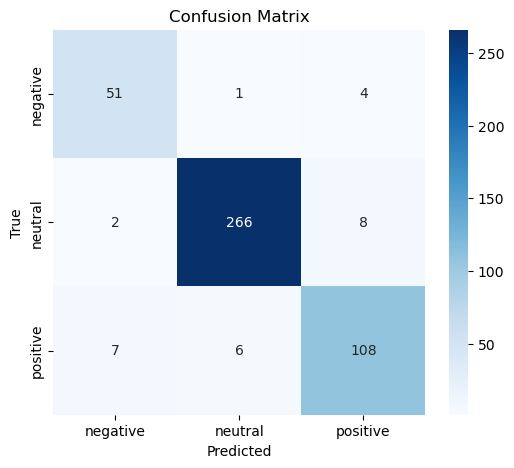

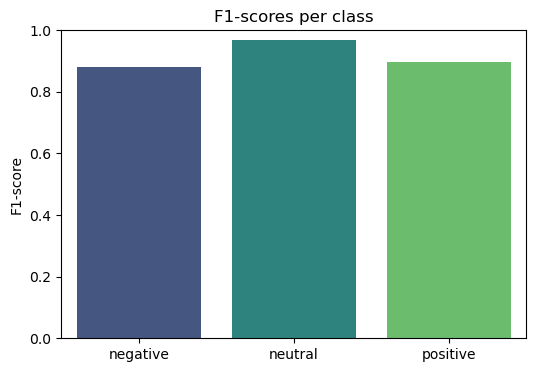

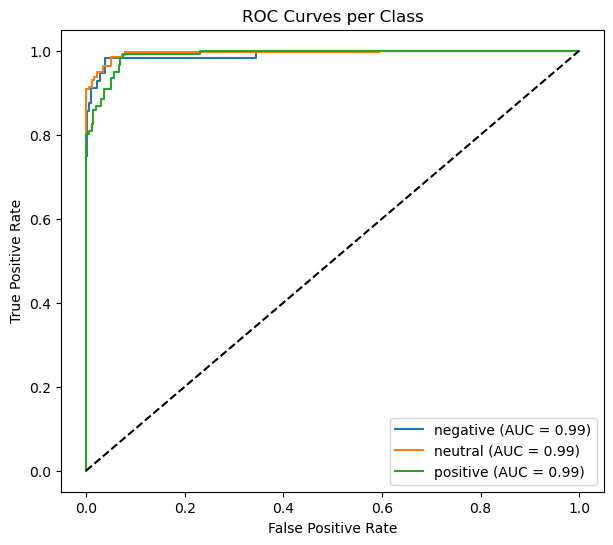


Example Inference → The bank is facing a major restructuring due to rising defaults.
Predicted Sentiment: negative


In [1]:
# ============================================================
# 🏦 Sentiment Analysis for Banking Texts using DistilBERT
# Dataset: Financial PhraseBank (100% Agreement version)
# Optimized for CPU with metrics & plots (incl. ROC/AUC)
# ============================================================

# 1. Install dependencies (run once if needed)
# !pip install transformers datasets torch evaluate scikit-learn matplotlib seaborn --quiet

# 2. Import libraries
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import evaluate
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Use all available CPU threads
torch.set_num_threads(torch.get_num_threads())

# ============================================================
# 📌 Load dataset
# ============================================================
df = pd.read_csv(
    "Sentences_AllAgree.txt",
    sep="@", header=None, encoding="latin-1",
    names=["sentence", "sentiment"]
)

# Encode labels
label_map = {"positive": 2, "neutral": 1, "negative": 0}
df["label"] = df["sentiment"].map(label_map)

# Train/test split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["sentence"].tolist(),
    df["label"].tolist(),
    test_size=0.2,
    random_state=42
)

# ============================================================
# 📌 Tokenization (limit sequence length to 128 for speed)
# ============================================================
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

train_encodings = tokenizer(train_texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
test_encodings = tokenizer(test_texts, padding=True, truncation=True, max_length=128, return_tensors="pt")

# ============================================================
# 📌 Build Dataset class for Trainer
# ============================================================
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_ds = SentimentDataset(train_encodings, train_labels)
test_ds = SentimentDataset(test_encodings, test_labels)

# ============================================================
# 📌 Load pre-trained DistilBERT model
# ============================================================
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

# ============================================================
# 📌 Define metrics (Accuracy)
# ============================================================
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return metric.compute(predictions=preds, references=labels)

# ============================================================
# 📌 Training arguments (tuned for CPU)
# ============================================================
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=20
)

# ============================================================
# 📌 Create Trainer
# ============================================================
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# ============================================================
# 📌 Train model
# ============================================================
trainer.train()

# ============================================================
# 📌 Evaluate with detailed metrics
# ============================================================
predictions = trainer.predict(test_ds)
y_pred = np.argmax(predictions.predictions, axis=-1)
y_true = predictions.label_ids
y_probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=["negative", "neutral", "positive"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["negative", "neutral", "positive"],
            yticklabels=["negative", "neutral", "positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Bar chart for F1-scores
report = classification_report(y_true, y_pred, target_names=["negative", "neutral", "positive"], output_dict=True)
f1_scores = [report[label]["f1-score"] for label in ["negative", "neutral", "positive"]]

plt.figure(figsize=(6,4))
sns.barplot(x=["negative", "neutral", "positive"], y=f1_scores, palette="viridis")
plt.title("F1-scores per class")
plt.ylabel("F1-score")
plt.ylim(0,1)
plt.show()

# ============================================================
# 📌 ROC / AUC curves for each class
# ============================================================
n_classes = 3
y_true_bin = label_binarize(y_true, classes=[0,1,2])

plt.figure(figsize=(7,6))
for i, label in enumerate(["negative", "neutral", "positive"]):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves per Class")
plt.legend()
plt.show()

# ============================================================
# 📌 Inference on new text
# ============================================================
text = "The bank is facing a major restructuring due to rising defaults."
inputs = tokenizer(text, return_tensors="pt")
outputs = model(**inputs)
pred = torch.argmax(outputs.logits).item()

labels = ["negative", "neutral", "positive"]
print("\nExample Inference →", text)
print("Predicted Sentiment:", labels[pred])


In [2]:
# ============================================================
# 📌 Save model & tokenizer
# ============================================================
save_dir = "./saved_model"
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

print(f"Model and tokenizer saved to {save_dir}")


Model and tokenizer saved to ./saved_model


In [10]:
# ============================================================
# 📌 Load model & tokenizer (in a new session)
# ============================================================
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

load_dir = "./saved_model"
loaded_tokenizer = DistilBertTokenizer.from_pretrained(load_dir)
loaded_model = DistilBertForSequenceClassification.from_pretrained(load_dir)

# Example inference with loaded model
text = "NVIDIA stock bull ride this week."
inputs = loaded_tokenizer(text, return_tensors="pt")
outputs = loaded_model(**inputs)
pred = torch.argmax(outputs.logits).item()

labels = ["negative", "neutral", "positive"]
print("Predicted Sentiment:", labels[pred])


Predicted Sentiment: neutral


In [13]:
import gymnasium as gym
from stable_baselines3 import DQN

# 1. بناء بيئة (هنا نستخدم CartPole كمثال بديل لبيئة مصرفية)
env = gym.make("CartPole-v1")

# 2. تهيئة نموذج DQN (Q-learning العميق)
model = DQN("MlpPolicy", env, verbose=1, learning_rate=1e-3, buffer_size=10000)

# 3. تدريب النموذج
model.learn(total_timesteps=20000)

# 4. اختبار النموذج
obs, _ = env.reset()
for _ in range(200):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    env.render()
    if terminated or truncated:
        obs, _ = env.reset()

env.close()


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 27.2     |
|    ep_rew_mean      | 27.2     |
|    exploration_rate | 0.948    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1387     |
|    time_elapsed     | 0        |
|    total_timesteps  | 109      |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.512    |
|    n_updates        | 2        |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.6     |
|    ep_rew_mean      | 20.6     |
|    exploration_rate | 0.922    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 638      |
|    time_elapsed     | 0        |
|    total_timesteps  | 165      |
| train/              |        